# Первая работа с генеративной моделью (VAE)

In [1]:
!pip install torchbearer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 7.3 MB/s eta 0:00:00


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

За основу возьмем [Beta-VAE](https://openreview.net/pdf?id=Sy2fzU9gl) модель. Текущая модель представляет из себя трехслойную CNN, похожую на Beta-VAE. Свертки 4*4 с небольшим заполнением помогают легко определять размеры выходных данных для каждого слоя

## Modeling

In [3]:
import torchbearer
from torchbearer import state_key

MU = state_key('mu')
LOGVAR = state_key('logvar')

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_size: int):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            # (B — batch size, 1 канал, 28×28 пикселей)
            nn.Conv2d(1, 32, kernel_size=4, stride=1, padding=2),  # B, 32, 28, 28
            nn.ReLU(True),
            # Страйд 2 → уменьшаем пространственный размер в 2 раза
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1), # B, 32, 14, 14
            nn.ReLU(True),
            # Еще раз уменьшаем на 2
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # B, 64, 7, 7
        )

        self.mu = nn.Linear(64 * 7 * 7, latent_size)
        self.logvar = nn.Linear(64 * 7 * 7, latent_size)

        self.upsample = nn.Linear(latent_size, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 1, 2)
        )

    def reparameterize(self, mu, logvar):
        '''
        Добавляем к нему немного случайного шума.
        Сила шума определяется logvar: если сеть уверена — шума мало, если не уверена — шума больше.
        '''
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu


    def forward(self, x, state):
        image = x

        '''
        1. Кодируем изображение:
        - Сначала фильтры ищут простые вещи: края, пятна
        - Потом следующие — более сложные: формы, куски цифр
        - По пути картинка становится всё меньше по размеру с более сжатой информацией
        - Преобразуем полученное в один единый список чисел
        '''
        x = self.encoder(x).relu().view(x.size(0), -1)

        '''
        2. Вычисляем среднее - основной типичный вариант кода для этой картинки.
        '''
        mu = self.mu(x)

        '''
        3. Вычисляем разброс - насколько сильно этот код может колебаться.
        '''
        logvar = self.logvar(x)

        '''
        4. Учимся описывать облако похожих картинок - извлекаем латентный код
        '''
        sample = self.reparameterize(mu, logvar)


        '''
        5. Восстанавливаем изображение по латентному коду и декодируем его,
        увеличивая размер и дорисовывая детали. Постепенно сеть размазывает
        и уточняет признаки, чтобы получилась цельная картинка.
        '''
        result = self.decoder(self.upsample(sample).relu().view(-1, 64, 7, 7))

        '''
        6. Сохраняем состояние на каждом шаге для функции потерь при обучении
        '''
        if state is not None:
            state[torchbearer.Y_TRUE] = image
            state[MU] = mu
            state[LOGVAR] = logvar

        return result


Так, модель будет кодировать входное изображение в латентное пространство, выберет значения из этого пространства и декодирует их для полуения выходных данных. Она также положит все, что нужно в state.

## Before training

Теперь загрузим данные

In [5]:
import torch
from torchvision import transforms
from torchvision.datasets import FashionMNIST


transform = transforms.Compose([transforms.ToTensor()])

train = FashionMNIST(root='../', train=True, transform=transform, download=True)
test = FashionMNIST(root='../', train=False, transform=transform)

trainget = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=8)
testget = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False, num_workers=8)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.11MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 54.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.9MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


В качестве loss функции будем использовать KL-дивергенцию.

KL-дивергенция — это мера того, насколько два распределения вероятностей отличаются друг от друга

```
Total Loss = Reconstruction Loss + β × KL Divergence

Reconstruction Loss (BCE/MSE): насколько восстановленная картинка похожа на оригинал

KL Divergence: насколько распределение кодов q(z|x) (от энкодера) похоже на стандартное N(0,1)
```

Пусть есть два мешка с шариками:
**Истинный мешок P** (реальность): 90% красных, 10% синих
**Предсказанный мешок Q** (модель): 70% красных, 30% синих

KL-дивергенция отвечает на вопрос:
> Если я буду вытаскивать шарики из мешка Q, но думать, что вероятности как в P — сколько я потеряю информации?


Будем использовать именно ее потому, что:
```
P(z) = N(0, 1)  ← стандартное нормальное
Q(z|x) = N(μ, σ) ← то, что выучил энкодер для картинки x
```
Q(z|x) должен быть похож на N(0,1) для каждой картинки x. Если все коды z лежат около (0,0) в нормальном облаке — можно генерировать новые картинки, просто семплируя из N(0,1). Латентное пространство становится гладким и непрерывным:

```
KL(N(μ,σ) || N(0,1)) = ½ × Σ [μ² + σ² - 1 - log(σ²)]

KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta

logvar = log(σ²) — логарифм дисперсии
mu.pow(2) — насколько далеко центр от нуля
logvar.exp() — насколько большая дисперсия (σ²)
1 + logvar — нормализация для стандартного нормального
beta — умножаем на вес β (по умолчанию 5 для β-VAE)
```

Реализуем лосс через декоратор для torchbearer

In [6]:
import torchbearer.callbacks as callbacks

def beta_kl(mu_key, logvar_key, beta=5):
    # Вызываем декоратор на каждом этапе обучения после forward И добавляем к общему лоссу
    # Неявно: total_loss = base_loss + callback(state)
    @callbacks.add_to_loss
    def callback(state):
        mu = state[mu_key]
        logvar = state[logvar_key]
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta
    return callback

Удобно будет также визуализировать некоторые этапы треннировочного процесса. У torchbearer есть функционал и для этого

In [7]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline

def plot_progress(key=torchbearer.Y_PRED, num_images=100, nrow=10):
    @callbacks.on_step_validation
    @callbacks.once_per_epoch
    def callback(state):
        images = state[key]
        image = make_grid(
            images[:num_images], nrow=nrow, normalize=True
        )[0, :, :]

        plt.imshow(image.detach().cpu().numpy(), cmap='gray')
        plt.show()

    return callback


## Trainig

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


0/20(t): loss=7111.5718, mse=0.0584, running_loss=6093.7803, running_mse=0.0453
1/20(t): loss=5907.752, mse=0.0424, running_loss=5769.2744, running_mse=0.0407
2/20(t): loss=5733.1104, mse=0.0398, running_loss=5694.9438, running_mse=0.039
3/20(t): loss=5659.0034, mse=0.0387, running_loss=5619.0273, running_mse=0.0383
4/20(t): loss=5611.2661, mse=0.038, running_loss=5676.0474, running_mse=0.0383
5/20(t): loss=5573.9111, mse=0.0375, running_loss=5558.0894, running_mse=0.0373
6/20(t): loss=5543.1724, mse=0.0371, running_loss=5572.0791, running_mse=0.0372
7/20(t): loss=5525.2725, mse=0.0368, running_loss=5488.0801, running_mse=0.0364
8/20(t): loss=5511.5981, mse=0.0365, running_loss=5529.4761, running_mse=0.0366
9/20(t): loss=5489.5078, mse=0.0363, running_loss=5479.6367, running_mse=0.0361
10/20(t): loss=5474.1807, mse=0.0361, running_loss=5444.1787, running_mse=0.0358
11/20(t): loss=5475.7217, mse=0.0359, running_loss=5467.4106, running_mse=0.0357
12/20(t): loss=5463.7461, mse=0.0358, run

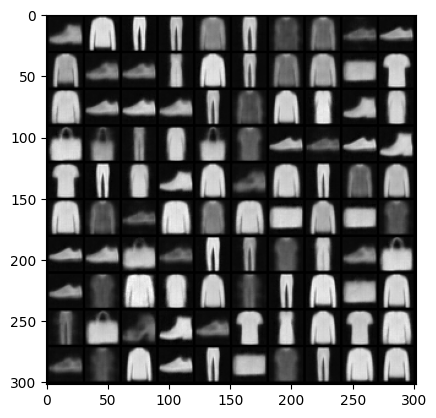

0/1(v): test_loss=4510.6763, test_mse=0.0265


{'test_mse': 0.0264980960637331, 'test_loss': 4510.67626953125}

In [8]:
import torch.optim as optim
from torchbearer import Trial

model = VAE(latent_size=10)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)

trial = Trial(model, optimizer, nn.MSELoss(reduction='sum'), metrics=['acc', 'loss'], callbacks=[
    beta_kl(MU, LOGVAR),
    callbacks.ConsolePrinter(),
    plot_progress()
], verbose=1).with_generators(train_generator=trainget, test_generator=testget)

trial.to('cuda')
trial.run(20)
trial.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)

In [18]:
torch.save({
    'model_stat_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'latent_size': 10,
    'input_size': 784 #(28×28),
}, 'vae_trained_model.pth')

## Images generation

In [19]:
model.eval().to('cuda')

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (mu): Linear(in_features=3136, out_features=10, bias=True)
  (logvar): Linear(in_features=3136, out_features=10, bias=True)
  (upsample): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
)

In [46]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def generate_64_pics():
    # Generate 64 new normalizing images from latent space
    with torch.no_grad():
        z = torch.randn(64, 10).to('cuda')  # 8x8 = 64
        generated = model.decoder(model.upsample(z).relu().view(-1, 64, 7, 7)).cpu()
        generated = torch.sigmoid(generated)

    # Generate grid
    grid_img = make_grid(generated, nrow=8, padding=2, normalize=True)

    # Show imgs
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray') # CHW -> HWC
    plt.axis('off')
    plt.title('VAE 8*8 generated images')
    plt.show()

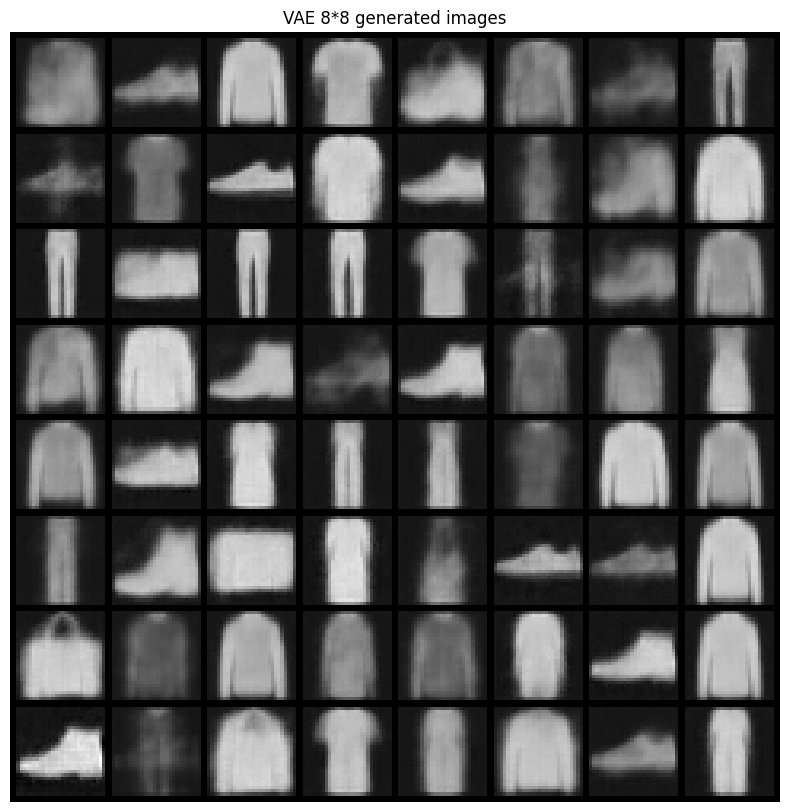

In [57]:
generate_64_pics()

## Interpolation

Полученное *латентное пространство* - это сжатая копия всех Fasion MNIST изображений в виде векторов (точек) в `latent_size=10` мерном пространстве.

Интерполяция - переход между двумя точками А и В
`(Тапок -> Тапок+Сумка -> Полусумка -> Сумка)`


**Цель:** Показать, что обученный VAE научился делать плавные переходы между сущностями латентного пространства

In [71]:
# Define usefull functions

def get_latent_codes(img):
    '''Из картинки → латентный вектор (mu)'''
    model.eval()

    with torch.no_grad():
        encoded = model.encoder(img.to('cuda')).view(img.size(0), -1)
        mu = model.mu(encoded)

    return mu.cpu()

def interpolate(z_a, z_b, steps=8):
    '''z_a → ... → z_b (8 шагов)'''
    alphas = torch.linspace(0, 1, steps)
    z_interp = (1-alphas[:,None]) * z_a + alphas[:,None] * z_b
    return z_interp

def decode_seq(z_seq):
    '''[8,10] → 8 картинок [8,1,28,28]'''
    model.eval()
    z_seq_gpu = z_seq.to('cuda')

    with torch.no_grad():
        upsampled = model.upsample(z_seq_gpu).relu()  # [8, 3136] cuda
        upsampled = upsampled.view(-1, 64, 7, 7)      # [8, 64, 7, 7] cuda
        decoded = model.decoder(upsampled)             # [8, 1, 28, 28] cuda

    return torch.sigmoid(decoded).cpu()            # [8, 1, 28, 28] CPU

In [80]:
test = next(iter(testget))
images = test[0]

images.shape

torch.Size([128, 1, 28, 28])

In [88]:
# Get 3 pairs of random images

rand_ind = torch.randperm(images.size(0))[:6]
target_images = images[rand_ind]

pairs = [
    (target_images[0:1], target_images[1:2]),
    (target_images[2:3], target_images[3:4]),
    (target_images[4:5], target_images[5:6])
]


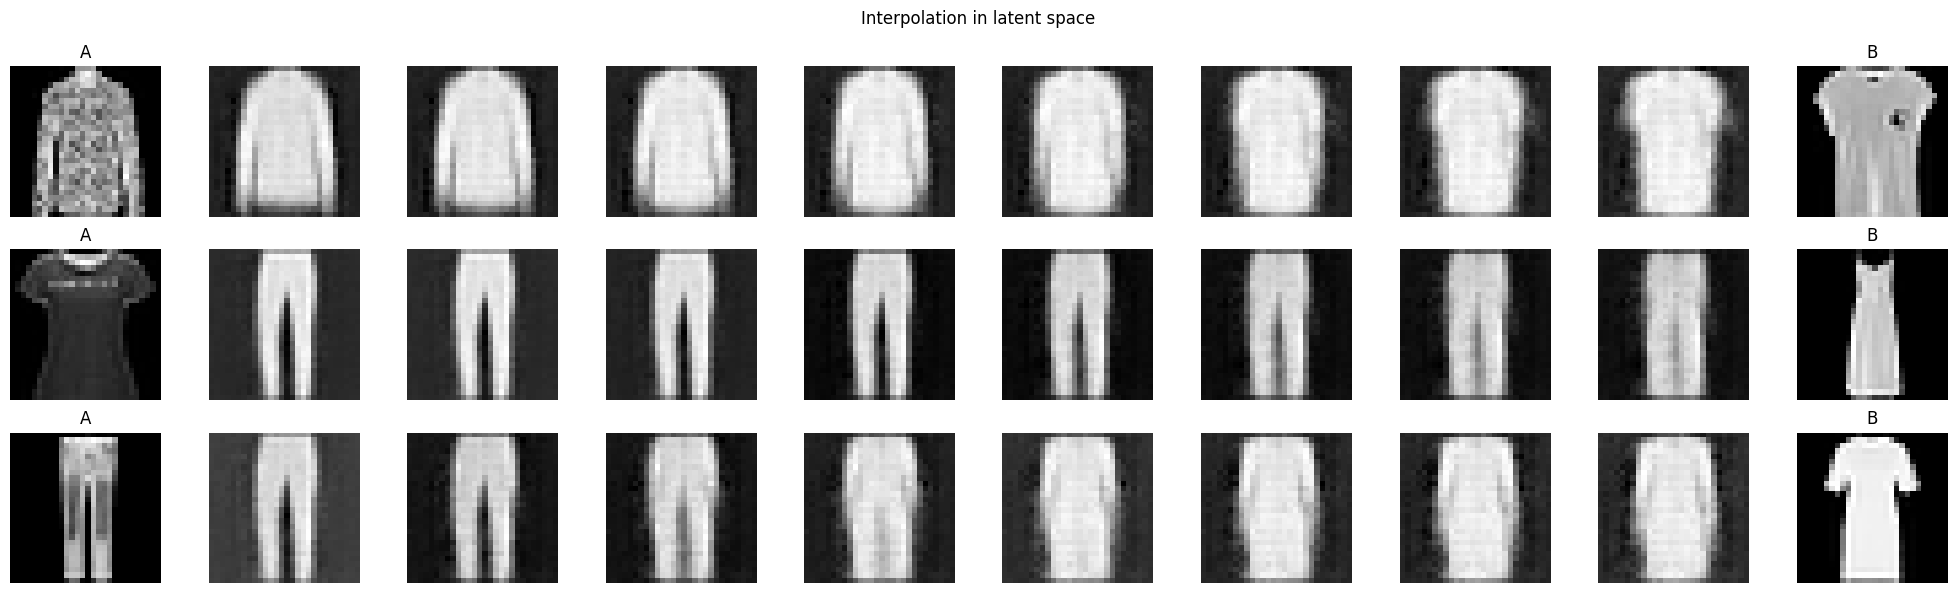

In [89]:
# Show images

fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i, (img_a, img_b) in enumerate(pairs):
    # Get latent codes
    z_a = get_latent_codes(img_a)
    z_b = get_latent_codes(img_b)

    # Interpolation
    z_interp = interpolate(z_a, z_b)

    # Decode
    img_interp = decode_seq(z_interp)

    # Show: a + 8 interpolations + b
    axes[i, 0].imshow(img_a.squeeze(), cmap='gray')
    axes[i, 0].set_title('A')
    axes[i, 0].axis('off')

    for j in range(8):
        axes[i, j+1].imshow(img_interp[j].squeeze(), cmap='gray')
        axes[i, j+1].axis('off')

    axes[i, -1].imshow(img_b.squeeze(), cmap='gray')
    axes[i, -1].set_title('B')
    axes[i, -1].axis('off')

plt.suptitle('Interpolation in latent space')
plt.tight_layout()
plt.show()


**Результаты**
1. Насколько осмысленными выглядят сгенерированные изображения:
    - Изображения осмысленные и узнаваемые по метрике (MSE=0.0265) и визуально
    - Присутствует типичное размытие, но семантика одежды сохраняется

2. Оценка интерполяции:
    - Переходы плавные и предсказуемые в большинстве случаев
    - Резких скачков и шума не наблюдается

3. Общие выводы:
    - Латентное пространство организовано семантически: единый класс кластеризуется близко
    - Выбранных 10 измерений достаточно для захвате ключевых признаков одежды
    - Результат при базовой VAE на 20 эпохах очень хороший
    - Интерполяция дает постепенную эволюцию формы
    - Интерполяция эффективна, а пути выглядят реалистично